In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
#using ControlSystems

### 2D Point Mass Continous dynamics

In [110]:
c = 0.1
m = 1.0
function point_mass(x, u)
   # x = state[1]                #x_1 = ẋ
    ẋ = x[3]
    ẍ = -(c/m)*ẋ + u[1]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    #y = state[3]
    ẏ = x[4]
    ÿ = -(c/m)*ẏ + u[2]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    return [ẋ; ẏ; ẍ; ÿ]
end

point_mass (generic function with 1 method)

### Linearizing and discretizing the dynamics

In [373]:
function lin_dyn_discrete(dynamics, x, u, dt)
    A = ForwardDiff.jacobian(dx -> dynamics(dx, u), x)
    B = ForwardDiff.jacobian(du -> dynamics(x, du), u)
    A = dt .* A + I
    B = dt .* B
    return A, B
end

lin_dyn_discrete (generic function with 1 method)

In [374]:
# Constraint 
obstacle = [10.0, 10.0, 0.0, 0.0]
dmax = 2.0

ρ = 6.0

6.0

In [375]:
xₜ = [10.0; 11.0; 0.0; 0.0]
(xₜ[1:2] - obstacle[1:2])'*(xₜ[1:2] - obstacle[1:2])

1.0

In [376]:
Q = 0.1*I(4) #state cost for point mass 1
R = 10.0*I(2)
Qn = 10.0*I(4)
function cost(x, u, xgoal, ugoal, B)

    goal = x - xgoal# check x or x̂
    rel_dist = (x[1:2] - obstacle[1:2])'*I*(x[1:2] - obstacle[1:2])
    if B 
        return 0.5*goal'*Qn*goal #+ ρ/(exp(rel_dist))
    else            
        dx = x - xgoal
        du = u - ugoal
        c = (rel_dist - dmax)
        if c < 0
            c = 0.0000000000000001
        end
        return 0.5*dx'*Q*dx + 0.5*du'*R*du #- (ρ)*log2(c)
        
    end
end

cost (generic function with 1 method)

### Cost Function (add distance constrain to arbitary static object)

In [377]:
# Q = 1.0*I(4) #state cost for point mass 1
# R = 1.0*I(2)
# Qn = 0.1*I(4)

# # function cost(x, u)
# #     c = 0.5*x'*Q*x + 0.5*u'*R*u + rho*min(sqrt((x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])), 0)
# #     return c
# # end

# function cost(x, u, xgoal, ugoal, B)

#     goal = x - xgoal# check x or x̂

#     if B 
#         return 0.5*goal'*Qn*goal
#     else            
#         dx = x - xgoal
#         du = u - ugoal
#         return 0.5*dx'*Q*dx + 0.5*du'*R*du
#     end
# end

# rel_dist = (x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])
# if rel_dist < dmax 
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - rel_dist
# else
#     outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*dmax))
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - outside_penalty - dmax
# end

### Quadritizing cost function

In [378]:
function quadratic_cost(cost_fun, x, u, xgoal, ugoal, B)
    """
    2nd order Taylor expansion of cost at t
    I neglected the mixed paritals in the hessian
    """
    Q = ForwardDiff.hessian(dx -> cost_fun(dx, u, xgoal, ugoal, B), x)
    l = ForwardDiff.gradient(dx -> cost_fun(dx, u, xgoal, ugoal, B), x)
    R = ForwardDiff.hessian(du -> cost_fun(x, du, xgoal, ugoal, B), u)
    r = ForwardDiff.gradient(du -> cost_fun(x, du, xgoal, ugoal, B), u)

    if B
        dx = x - xgoal
        du = u
    else
        dx = x - xgoal
        du = u - ugoal
    end
    cost = 0.5 * dx' * (Q*dx + 2*l) + 0.5 * du' * (R*du + 2*r)
    return cost, Q, l, R, r
end

quadratic_cost (generic function with 1 method)

In [379]:
function compute_quad_cost(cost_fun, l, r, x, u, xgoal, ugoal, B)
    l = ForwardDiff.gradient(dx -> cost_fun(dx, u, xgoal, ugoal, B), x)
    r = ForwardDiff.gradient(du -> cost_fun(x, du, xgoal, ugoal, B), u)
    dx = x - xgoal
    du = u - ugoal
    cost = dx' *l + du' * r
    return cost
end

compute_quad_cost (generic function with 1 method)

In [380]:
xₜ = [10; 10.0; 0.0; 0.0]
xgoal = [20.0; 20.0; 0.0; 0.0]
ugoal = [0, 0]
uₜ = [2.0; 2.0]
rel_dist = (xₜ[1:2] - obstacle[1:2])'*I*(xₜ[1:2] - obstacle[1:2])
println("rel_dist ", rel_dist)
costs, Qₜ, lₜ, Rₜ, rₜ = quadratic_cost(cost, xₜ, uₜ, xgoal, ugoal, false)
println("actual cost ", cost(xₜ, uₜ, xgoal, ugoal, false))
@show costs
@show Qₜ
@show lₜ
@show Rₜ
@show rₜ

rel_dist 0.0
actual cost 50.0
costs = 150.0
Qₜ = [0.1 0.0 0.0 0.0; 0.0 0.1 0.0 0.0; 0.0 0.0 0.1 0.0; 0.0 0.0 0.0 0.1]
lₜ = [-1.0, -1.0, 0.0, 0.0]
Rₜ = [10.0 0.0; 0.0 10.0]
rₜ = [20.0, 20.0]


2-element Vector{Float64}:
 20.0
 20.0

#### Point Mass Discrete

$$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$


### Single Iteration of Affine QR

In [381]:
n = 4 #8 states
m = 2 #2 controls
function affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ)

    V = copy(Qₜ[:,:,end]) #at last time step
    ζ = copy(lₜ[:,end]) #at last time step
    #P = zeros(k_steps, n*m)
    P = zeros(Float32, (m, n, k_steps))
    #α = zeros(k_steps, m)
    α = zeros(Float32, (m, k_steps))

    #α₂ = zeros(T[1], m)

    for t in (k_steps-1):-1:1
        # solving for Ps, check equation 19 in document
        # Player 1
        # Equation (10) only for 1 player for Pⱼ = 0 
        # println(Rₜ[:,:,t])
        # println(Bₜ[:,:,t])
        # println(V)
        Pₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * V * Aₜ[:,:,t])
        # Equation (11) only for 1 player for for αⱼ = 0
        αₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * ζ)
        # Assign Values
        P[:,:,t] = Pₜ
        α[:,t] = αₜ
        #Update value function(s)
        # Equation (14)
        Fₜ = Aₜ[:,:,t] - (Bₜ[:,:,t]*Pₜ)
        # Equation (15)
        βₜ = - Bₜ[:,:,t] * αₜ
        # Equation (17)
        ζ = lₜ[:,t] + (Pₜ' * Rₜ[:,:,t] * αₜ - Pₜ' * rₜ[:,t]) + Fₜ'*(ζ + V * βₜ)
        # Equation (16) where V = Z
        V = Qₜ[:,:,t] + (Pₜ' * Rₜ[:,:,t] * Pₜ) + (Fₜ' * V * Fₜ)
    end
    return P, α
end

affinelq! (generic function with 1 method)

### Rollout a (nonlinear) trajectory

In [382]:
x = [0,0]
lo = [-1,1]
hi = [2,2]
x .= clamp.(x, lo, hi)

2-element Vector{Int64}:
 0
 1

In [388]:
function Rollout_RK4(fun, x₀, x̂, û, H, dt, P, α, α_scale)
    """
    Rollout dynamics with initial state x₀ 
    and control law u = -Px - α
    P is an n x b gain matrix
    α is m x 1
    """
    umax = [2,2]
    umin = [-2,-2]
    m = 2 #2 controls
    k_steps = trunc(Int, H/dt) 
    xₜ = zeros(k_steps, length(x₀)) # 1500 x n
    uₜ = zeros(k_steps, m) 
    xₜ[1,:] .= x₀
    for t=1:(k_steps-1)
        # WHAT IS x̂ in xₜ[t,:] - x̂
        #uₜ[t,:] .= clamp.([0,0] - P[:,:,t]*(xₜ[t,:] - [20,20,0,0]) - α[:,t], umin, umax)
        uₜ[t,:] .= clamp.(û[t,:] - P[:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[:,t], umin, umax)
        k1 = fun(xₜ[t,:], uₜ[t,:])
        k2 = fun(xₜ[t,:] + 0.5*dt*k1, uₜ[t,:])
        k3 = fun(xₜ[t,:] + 0.5*dt*k2, uₜ[t,:])
        k4 = fun(xₜ[t,:] + dt*k3, uₜ[t,:])
        xₜ[t+1,:] = xₜ[t,:] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    end
    
    return xₜ, uₜ
end

Rollout_RK4 (generic function with 1 method)

In [389]:
function isConverged(current, last, tolerance = 1e-4)
    if norm(current - last) > tolerance
        return false
    else 
        return true
    end
end

isConverged (generic function with 2 methods)

### Initiating P's and alpha's

In [390]:
# x₀=[0; 0; 0; 0]
dt = 0.1 #step size
H = 15.0  #Horizon
k_steps = Int(H/dt)

P = rand(2,4,k_steps)*0.1
α = rand(2,k_steps)*0.1

2×150 Matrix{Float64}:
 0.0567182  0.0968195  0.0593041  …  0.00132178  0.0335652  0.0661092
 0.0711047  0.0604047  0.0420937     0.00777582  0.0546339  0.00487481

In [391]:
#function ilqr()
# 1. Initialize an initial feasible trajectory

n = 4
m = 2
x₀ = [0.0; 0.0; 0.0; 0.0]
xgoal = [20.0; 20.0; 0.0; 0.0]
x̂ = zeros(k_steps, length(x₀)) # 1500 x need
û = zeros(k_steps, m) 
xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α, 1.0) #xₜ is [k_steps, 4]
Aₜ = zeros(Float32, (n, n, k_steps))
Bₜ = zeros(Float32, (n, m, k_steps))
Qₜ = zeros(Float32, (n, n, k_steps))
lₜ = zeros(Float32, (n, k_steps))
Rₜ = zeros(Float32, (m, m, k_steps))
rₜ = zeros(Float32, (m, k_steps))
costs = zeros(k_steps);

# x̂ = xₜ
# û = uₜ

In [392]:
#println(total_cost)
converged = false
ugoal = [0, 0]
all_cost = []
βreg = 1.0
αₗ = [1.0, 0.6, 0.4, 0.2, 0.1, 0.01]
while !converged
#for i in 1:50
    converged = isConverged(xₜ, x̂, 1e-5)
    #println(converged)
    total_cost = 0
    for t = 1:(k_steps-1)
        # 2. Linearize dynamics about trajectory
        # WHAT IS x̂ in xₜ[t,:] - x̂
        dx = xₜ[t,:] - x̂[t,:]
        du = uₜ[t,:] - û[t,:]
        Aₜ[:,:,t], Bₜ[:,:,t] = lin_dyn_discrete(point_mass, dx, du, dt)
        # 3. Compute second order Taylor series expansion the cost function
        # WHAT IS x̂ in xₜ[t,:] - x̂
        costval, Qₜ[:,:,t], lₜ[:,t], Rₜ[:,:,t], rₜ[:,t] = quadratic_cost(cost, xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)

        # Regularization
        while !isposdef(Qₜ[:,:,t])
            Qₜ[:,:,t] = Qₜ[:,:,t] + βreg*I
        end
        # @show Rₜ[:,:,t] 
        total_cost += costval 
    end
    costval, Qₜ[:,:,end], lₜ[:,end], Rₜ[:,:,end], rₜ[:,end] = quadratic_cost(cost, xₜ[end,:], uₜ[end,:], xgoal, ugoal, true)

    total_cost += costval
    # @show costs[end]
    # 4. Do lqr
    P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);

    x̂ = xₜ
    û = uₜ
    xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α, 1.0)
    #println(converged)

    push!(all_cost, total_cost)
    #@show xₜ[1,:] 
    #@show xₜ[end,:]
    @show total_cost
end

total_cost = 31431.491941342545
total_cost = 7729.896774537562
total_cost = 8377.67368311662
total_cost = 8977.151148901801
total_cost = 9270.409504286585
total_cost = 9389.528669302399
total_cost = 9453.000599501012
total_cost = 9478.696784458238
total_cost = 9473.669205593531
total_cost = 9475.23024644589
total_cost = 9490.317852801703
total_cost = 9507.286266047042
total_cost = 9508.846464604503
total_cost = 9490.411944059411
total_cost = 9462.770134983593
total_cost = 9435.358032021637
total_cost = 9413.724825491245
total_cost = 9399.039093109306
total_cost = 9389.871649720917
total_cost = 9384.368001682322
total_cost = 9381.509942073184
total_cost = 9381.191509442044
total_cost = 9383.57235513411
total_cost = 9388.371152415304
total_cost = 9394.549870389057
total_cost = 9400.487799755909
total_cost = 9404.468546569646
total_cost = 9405.207195140096
total_cost = 9402.192846364462
total_cost = 9395.75213363272
total_cost = 9386.864524777122
total_cost = 9376.8397266723
total_cost = 

total_cost = 9507.693854771183
total_cost = 9507.708385295931
total_cost = 9507.718280468798
total_cost = 9507.724388876723
total_cost = 9507.727647568729
total_cost = 9507.728723524237
total_cost = 9507.728503951424
total_cost = 9507.727724910996
total_cost = 9507.727128728646
total_cost = 9507.727354661725
total_cost = 9507.729182742729
total_cost = 9507.732994852822
total_cost = 9507.739623290056
total_cost = 9507.74932521763
total_cost = 9507.762618119234
total_cost = 9507.779847745107
total_cost = 9507.801384045139
total_cost = 9507.82743075824
total_cost = 9507.858093331506
total_cost = 9507.893666599824
total_cost = 9507.93419471245
total_cost = 9507.97961840012
total_cost = 9508.029929791988
total_cost = 9508.085163944152
total_cost = 9508.14496248168
total_cost = 9508.209306768178
total_cost = 9508.277939256439
total_cost = 9508.350633083448
total_cost = 9508.427013421806
total_cost = 9508.506886354962
total_cost = 9508.58981398084
total_cost = 9508.675466096767
total_cost = 9

total_cost = 9512.646418219392
total_cost = 9512.64001552377
total_cost = 9512.63346004671
total_cost = 9512.626848441507
total_cost = 9512.620203097547
total_cost = 9512.6134802062
total_cost = 9512.606687188323
total_cost = 9512.599853782853
total_cost = 9512.59282762
total_cost = 9512.58569085093
total_cost = 9512.578406054516
total_cost = 9512.57100651012
total_cost = 9512.563499240194
total_cost = 9512.555897730052
total_cost = 9512.54818997372
total_cost = 9512.540383945241
total_cost = 9512.532472054574
total_cost = 9512.524418816922
total_cost = 9512.51625106813
total_cost = 9512.507954395309
total_cost = 9512.499578937975
total_cost = 9512.490982162562
total_cost = 9512.482264968314
total_cost = 9512.473448928142
total_cost = 9512.464475923565
total_cost = 9512.455378292532
total_cost = 9512.44621010492
total_cost = 9512.436870751213
total_cost = 9512.427433422701
total_cost = 9512.417930477555
total_cost = 9512.408267369383
total_cost = 9512.398521016501
total_cost = 9512.388

total_cost = 9509.128741537066
total_cost = 9509.116756734968
total_cost = 9509.104495714135
total_cost = 9509.092603843059
total_cost = 9509.080543188804
total_cost = 9509.06863635882
total_cost = 9509.056832657172
total_cost = 9509.044869531563
total_cost = 9509.033212349295
total_cost = 9509.02138976885
total_cost = 9509.009808133658
total_cost = 9508.998056140457
total_cost = 9508.986596476068
total_cost = 9508.97498769136
total_cost = 9508.963639626145
total_cost = 9508.952121858438
total_cost = 9508.940774881878
total_cost = 9508.929441270893
total_cost = 9508.918206991011
total_cost = 9508.906954593178
total_cost = 9508.895838704284
total_cost = 9508.884685247782
total_cost = 9508.873648971943
total_cost = 9508.862623496923
total_cost = 9508.851654514352
total_cost = 9508.840766644822
total_cost = 9508.829881011316
total_cost = 9508.819123496696
total_cost = 9508.80826903818
total_cost = 9508.797706214784
total_cost = 9508.786895398502
total_cost = 9508.776428436284
total_cost =

In [393]:
#     for α_scale in αₗ
#         xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α, α_scale)
#         costₙ = 0
#         for t = 1:(k_steps-1)
#             costNow, ~, ~, ~, ~ = quadratic_cost(cost, xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)
#             #costₙ += compute_quad_cost(cost, lₜ[:,t], rₜ[:,t], xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)
#             costₙ += costNow
#         end
#         costNow, ~, ~, ~, ~ = quadratic_cost(cost, xₜ[end,:], uₜ[end,:], xgoal, ugoal, true)
#         costₙ += costNow
#         #costₙ += compute_quad_cost(cost, lₜ[:,end], rₜ[:,end], xₜ[end,:], uₜ[end,:], xgoal, ugoal, true)
#         if costₙ < total_cost
#             break
#         # else 
#         #     converged = true
#         end
#     end

In [394]:
all_cost

954-element Vector{Any}:
 31431.491941342545
  7729.896774537562
  8377.67368311662
  8977.151148901801
  9270.409504286585
  9389.528669302399
  9453.000599501012
  9478.696784458238
  9473.669205593531
  9475.23024644589
  9490.317852801703
  9507.286266047042
  9508.846464604503
     ⋮
  9508.001000412478
  9507.994505674153
  9507.988896024759
  9507.982495647608
  9507.976938247006
  9507.970678059666
  9507.965120522616
  9507.95903361772
  9507.95356289561
  9507.947517323048
  9507.942000920086
  9507.93621923314

In [395]:
xₜ[end, :] #45757

4-element Vector{Float64}:
 19.334222580657435
 19.33423626409775
 -0.0004470036685577522
 -0.0004886711422393414

┌ Info: Saved animation to /Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/obstacle.gif
└ @ Plots /Users/mohsafwat/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/obstacle.gif")
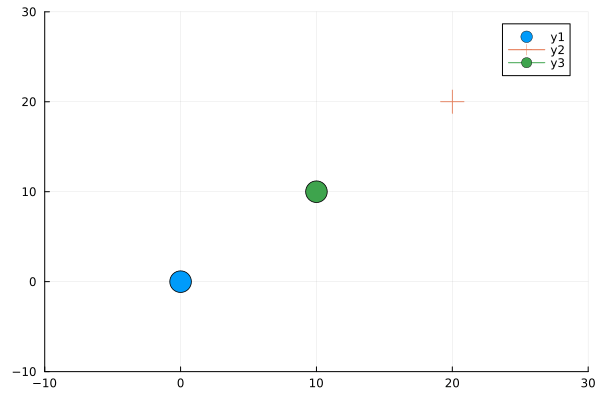

In [396]:
anim = @animate for t in 1:k_steps
    scatter([xₜ[t, 1]], [xₜ[t, 2]], m = (:circle, 12),
    xlims = (-10, 30), 
    ylims = (-10, 30), )
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
    plot!([obstacle[1]], [obstacle[2]], m = (:circle, 12))
end every 10;
gif(anim, "obstacle.gif")

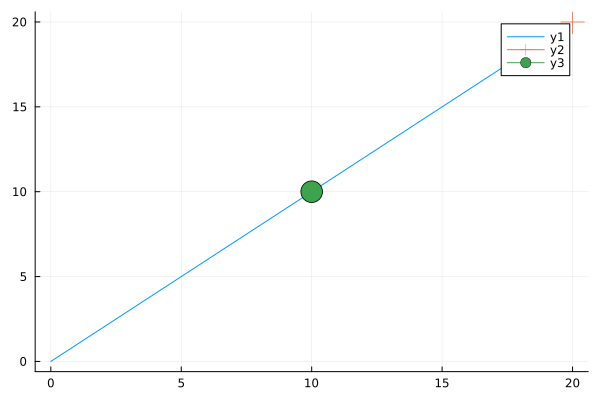

In [397]:
plot([xₜ[:, 1]], [xₜ[:, 2]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!([obstacle[1]], [obstacle[2]], m = (:circle, 12))

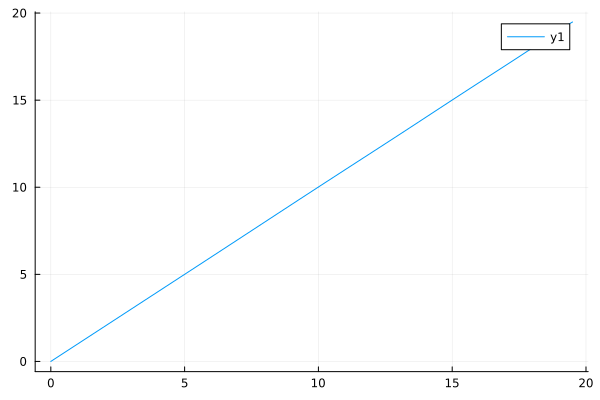

In [354]:
plot([xₜ[:, 1]], [xₜ[:, 2]])

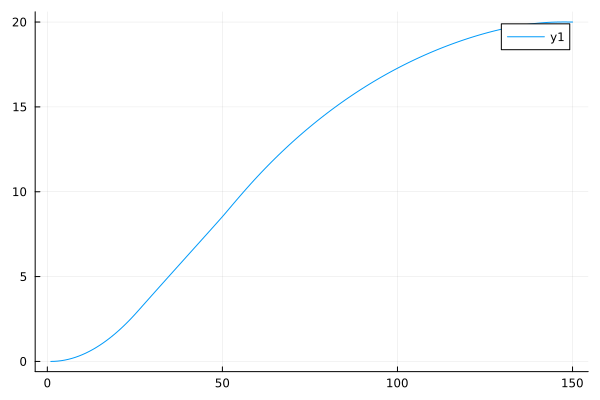

In [314]:
plot([xₜ[:, 2]])

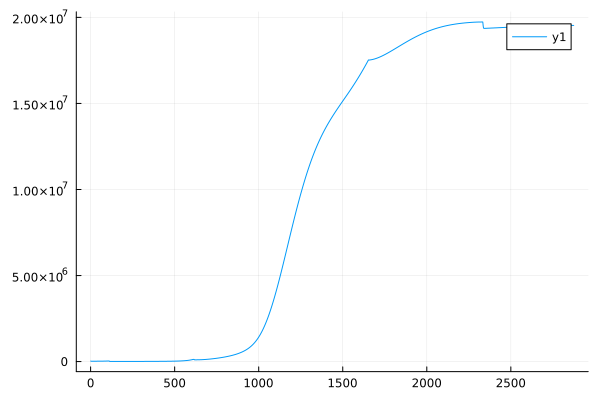

In [155]:
plot(all_cost)

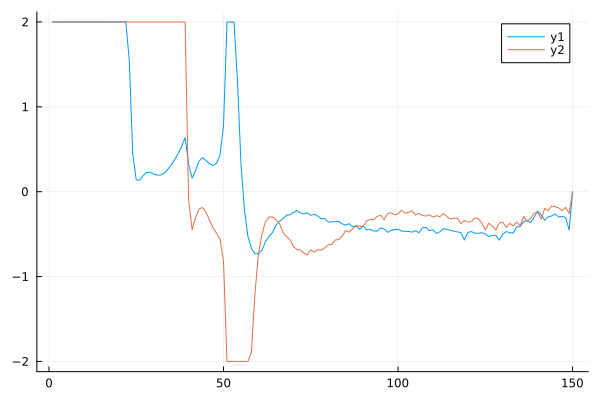

In [74]:
plot(uₜ)

In [75]:
xₜ[105,:]

4-element Vector{Float64}:
 18.795776880925356
 19.568702862661482
  1.1563104967274442
  0.8255745077600577